In [12]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from models import *

In [13]:
model_name = 'f'
dataset_name = 'alphabet'

In [14]:
label_encoder = LabelEncoder()

full_path = 'datasets'+'\\'+dataset_name+'.npz'
dataset = np.load(full_path)
x = dataset['x']
y = label_encoder.fit_transform(list(dataset['y']))

ndata, ntimestep, nchannels  = x.shape
nclasses = len(label_encoder.classes_)
print(f'ndata: {ndata} , ntimestep: {ntimestep} , nchannels: {nchannels}')

ndata: 150 , ntimestep: 2048 , nchannels: 6


In [15]:
ndata_train = int(0.8*ndata)
ndata_eval = int(0.2*ndata)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=ndata_eval, random_state=42)

In [16]:
x_temp = x_train.reshape([-1, nchannels])
mean_arr = x_temp.mean(axis=0)
std_arr = x_temp.std(axis=0)

x_train_n = torch.tensor(((x_train-mean_arr)/std_arr).transpose([0, 2, 1]), dtype=torch.float32)
x_eval_n = torch.tensor(((x_eval-mean_arr)/std_arr).transpose([0, 2, 1]), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_eval = torch.tensor(y_eval, dtype=torch.long)

In [17]:
train_dataset = TensorDataset(x_train_n, y_train)
eval_dataset = TensorDataset(x_eval_n, y_eval)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [18]:
model = ex(nchannels=nchannels, nclasses=nclasses)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
nepoch = 40
train_loss_list = []
eval_loss_list = []

for epoch in range(nepoch):
    model.train()
    train_loss = 0
    for (inputs, labels) in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss/len(train_dataloader))

    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for (inputs, labels) in eval_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
    eval_loss_list.append(eval_loss/len(eval_dataloader))
    print(f'Epoch [{epoch+1}/{nepoch}], Train Loss: {train_loss_list[-1]:.4f}, Eval Loss: {eval_loss_list[-1]:.4f}')

Epoch [1/40], Train Loss: 1.6432, Eval Loss: 1.6209
Epoch [2/40], Train Loss: 1.6097, Eval Loss: 1.6127
Epoch [3/40], Train Loss: 1.6096, Eval Loss: 1.6147
Epoch [4/40], Train Loss: 1.6081, Eval Loss: 1.6159
Epoch [5/40], Train Loss: 1.6093, Eval Loss: 1.6180
Epoch [6/40], Train Loss: 1.6302, Eval Loss: 1.6067
Epoch [7/40], Train Loss: 1.6144, Eval Loss: 1.6225
Epoch [8/40], Train Loss: 1.6110, Eval Loss: 1.6124
Epoch [9/40], Train Loss: 1.6118, Eval Loss: 1.6128
Epoch [10/40], Train Loss: 1.6095, Eval Loss: 1.6167
Epoch [11/40], Train Loss: 1.6089, Eval Loss: 1.6161
Epoch [12/40], Train Loss: 1.6078, Eval Loss: 1.6120
Epoch [13/40], Train Loss: 1.5759, Eval Loss: 1.6557
Epoch [14/40], Train Loss: 1.6116, Eval Loss: 1.5985
Epoch [15/40], Train Loss: 1.4005, Eval Loss: 1.1913
Epoch [16/40], Train Loss: 1.2827, Eval Loss: 0.9300
Epoch [17/40], Train Loss: 0.8699, Eval Loss: 0.7746
Epoch [18/40], Train Loss: 0.5717, Eval Loss: 0.9571
Epoch [19/40], Train Loss: 0.5193, Eval Loss: 1.2184
Ep

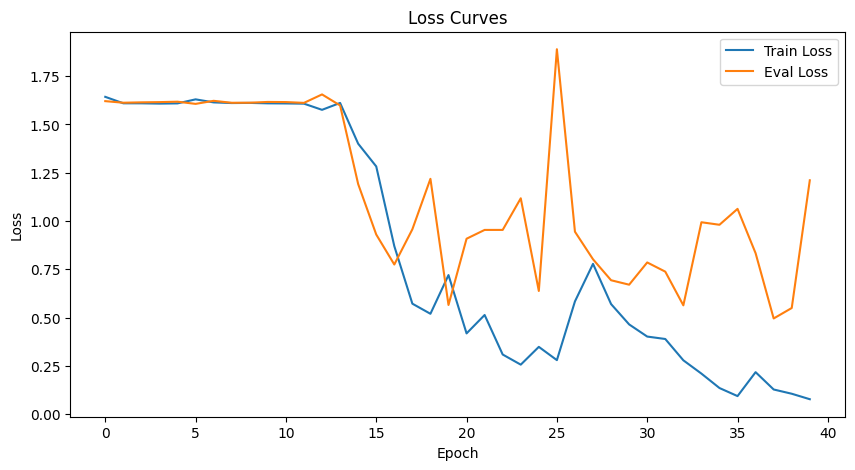

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(nepoch), train_loss_list, label='Train Loss')
plt.plot(range(nepoch), eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

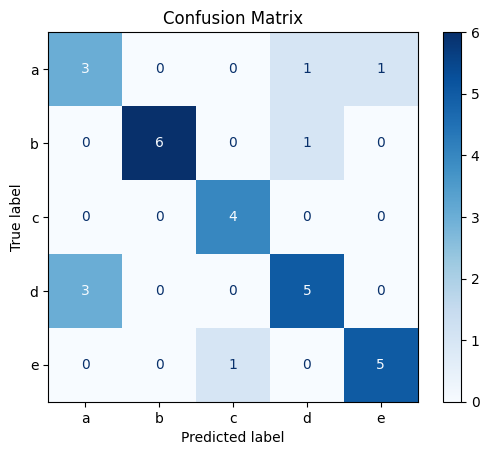

In [21]:

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in eval_dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds)
        all_labels.append(labels)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
